# 니켈 가격 예측: sparta2 이후 고급 기법 적용

## 연구 목적
sparta2에서 달성한 **Hybrid (Naive Drift × 0.8 + GradientBoosting × 0.2) RMSE 406.80**을 개선하기 위한 체계적 실험

## 연구 방법론
1. **탐색적 데이터 분석 (EDA)**: 시계열 특성 파악
2. **피처 엔지니어링**: 기술적 지표 및 파생 피처 생성
3. **피처 중요도 분석**: 모델 기반 피처 선택
4. **하이퍼파라미터 최적화**: GridSearchCV 적용
5. **고급 앙상블**: Stacking, 적응형 가중치
6. **엄격한 검증**: Time Series CV

## Data Leakage 방지 전략
- 모든 피처에 `shift(1)` 적용
- 시간순 분할: Train → Validation → Test


---
# 1. 환경 설정


In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Mac)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 시각화 설정
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# 상수 정의
SPARTA2_RMSE = 406.80
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 날짜 설정 (datetime으로 변환)
VAL_START = pd.to_datetime('2025-08-04')
VAL_END = pd.to_datetime('2025-10-20')
TEST_START = pd.to_datetime('2025-10-27')
TEST_END = pd.to_datetime('2026-01-12')

# 결과 저장
experiment_results = []

print('환경 설정 완료')
print(f'기준선 (sparta2): RMSE {SPARTA2_RMSE}')


환경 설정 완료
기준선 (sparta2): RMSE 406.8


---
# 2. 데이터 로드 및 탐색


In [155]:
# 데이터 로드
df = pd.read_csv('data_weekly_260120.csv')
df['dt'] = pd.to_datetime(df['dt'])
df = df.set_index('dt').sort_index()

target_col = 'Com_LME_Ni_Cash'
price = df[target_col].copy()

print('='*60)
print('데이터 개요')
print('='*60)
print(f'기간: {df.index.min().date()} ~ {df.index.max().date()}')
print(f'총 관측치: {len(df)}주')
print(f'피처 수: {len(df.columns)}')
print(f'\n타겟 변수 통계:')
print(price.describe().round(2))


데이터 개요
기간: 2013-04-01 ~ 2026-01-12
총 관측치: 668주
피처 수: 74

타겟 변수 통계:
count      668.00
mean     15521.66
std       4760.67
min       7925.00
25%      12340.88
50%      14957.40
75%      17804.75
max      33781.25
Name: Com_LME_Ni_Cash, dtype: float64


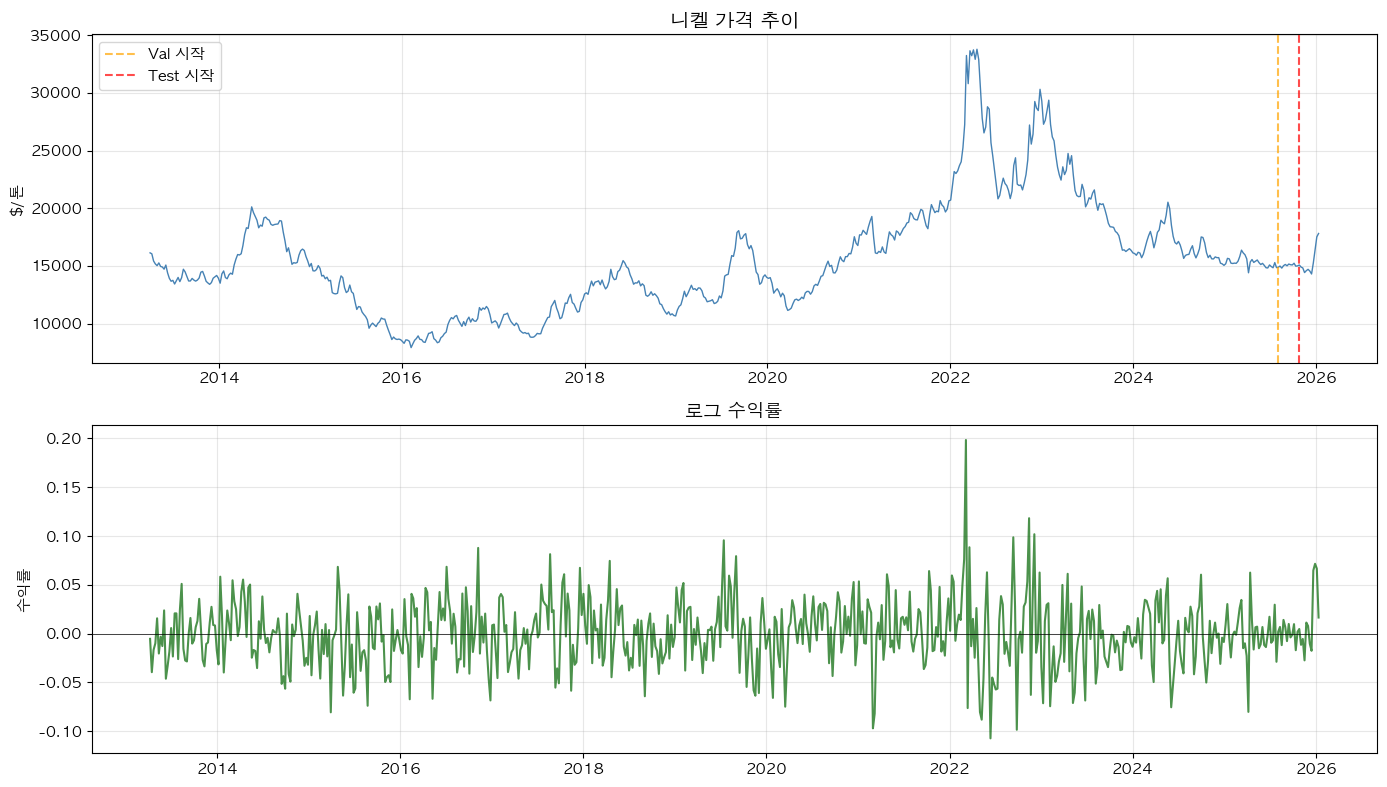

In [156]:
# 시계열 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 전체 가격 추이
ax1 = axes[0]
ax1.plot(price, color='steelblue', linewidth=1)
ax1.axvline(VAL_START, color='orange', linestyle='--', alpha=0.7, label='Val 시작')
ax1.axvline(TEST_START, color='red', linestyle='--', alpha=0.7, label='Test 시작')
ax1.set_title('니켈 가격 추이', fontweight='bold', fontsize=14)
ax1.set_ylabel('$/톤')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 로그 수익률
log_ret = np.log(price / price.shift(1)).dropna()
ax2 = axes[1]
ax2.plot(log_ret, color='darkgreen', alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_title('로그 수익률', fontweight='bold')
ax2.set_ylabel('수익률')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


기간별 특성:
   기간  샘플수       평균  수익률(%)  변동성
Train  644 15533.55   -7.93 0.24
  Val   12 15038.10    0.81 0.07
 Test   12 15367.03   18.14 0.26


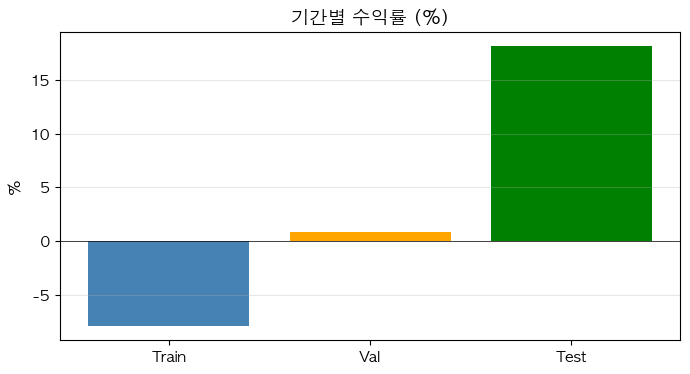


📊 Test 기간 수익률: 18.1%
   → 상승 추세 → Naive 모델에 유리


In [157]:
# 기간별 특성 비교
train_price = price[price.index < VAL_START]
val_price = price[(price.index >= VAL_START) & (price.index <= VAL_END)]
test_price = price[(price.index >= TEST_START) & (price.index <= TEST_END)]

def calc_stats(p, name):
    ret = np.log(p / p.shift(1)).dropna()
    return {
        '기간': name,
        '샘플수': len(p),
        '평균': p.mean(),
        '수익률(%)': (p.iloc[-1]/p.iloc[0] - 1) * 100,
        '변동성': ret.std() * np.sqrt(52) if len(ret) > 0 else 0
    }

stats = pd.DataFrame([
    calc_stats(train_price, 'Train'),
    calc_stats(val_price, 'Val'),
    calc_stats(test_price, 'Test'),
])
print('기간별 특성:')
print(stats.round(2).to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(stats['기간'], stats['수익률(%)'], color=['steelblue', 'orange', 'green'])
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('기간별 수익률 (%)', fontweight='bold')
ax.set_ylabel('%')
ax.grid(True, alpha=0.3, axis='y')
plt.show()

print(f'\n📊 Test 기간 수익률: {stats[stats["기간"]=="Test"]["수익률(%)"].values[0]:.1f}%')
print('   → 상승 추세 → Naive 모델에 유리')


---
# 3. 기준선 재현


In [ ]:
# 데이터 분할
train = df[df.index < VAL_START]
val = df[(df.index >= VAL_START) & (df.index <= VAL_END)]
test = df[(df.index >= TEST_START) & (df.index <= TEST_END)]

y_train = train[target_col]
y_val = val[target_col]
y_test = test[target_col]

print(f'Train: {len(train)}주 | Val: {len(val)}주 | Test: {len(test)}주')

# Naive Drift 함수
def calc_naive_drift(indices, damping=1.0):
    preds = []
    for idx in indices:
        loc = price.index.get_loc(idx)
        if loc >= 2:
            drift = price.iloc[loc-1] - price.iloc[loc-2]
            preds.append(price.iloc[loc-1] + damping * drift)
        else:
            preds.append(price.iloc[loc-1] if loc >= 1 else price.iloc[0])
    return np.array(preds)

naive_val = calc_naive_drift(val.index)
naive_test = calc_naive_drift(test.index)

# 피처 준비 (누수 방지: 1주 지연 적용)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != target_col and not train[c].isna().all()]

# sparta2와 동일하게 shift(1) 적용 → t시점 예측에 t-1시점 피처만 사용
X_shifted = df[features].shift(1)
X_shifted = X_shifted.fillna(method='ffill').fillna(method='bfill').fillna(0)

X_train = X_shifted.loc[train.index]
X_val = X_shifted.loc[val.index]
X_test = X_shifted.loc[test.index]

print(f'피처 수: {len(features)}개')
print('shift(1) 적용 완료 (Data Leakage 방지)')

In [ ]:
# 기준선 모델 학습 (sparta2와 동일 파라미터)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

gb_val = gb.predict(X_val)
gb_test = gb.predict(X_test)

# Hybrid 예측
hybrid_test = 0.8 * naive_test + 0.2 * gb_test
baseline_rmse = np.sqrt(mean_squared_error(y_test, hybrid_test))

print('='*60)
print('기준선 재현 결과')
print('='*60)
print(f'Naive Drift: RMSE {np.sqrt(mean_squared_error(y_test, naive_test)):.2f}')
print(f'GB 단독: RMSE {np.sqrt(mean_squared_error(y_test, gb_test)):.2f}')
print(f'Hybrid (0.8:0.2): RMSE {baseline_rmse:.2f}')
print(f'sparta2 결과: {SPARTA2_RMSE}')
print(f'차이: {baseline_rmse - SPARTA2_RMSE:+.2f}')

experiment_results.append({
    'Experiment': 'Baseline',
    'Model': 'Hybrid (Naive×0.8 + GB×0.2)',
    'RMSE': baseline_rmse,
    'Improvement': SPARTA2_RMSE - baseline_rmse
})

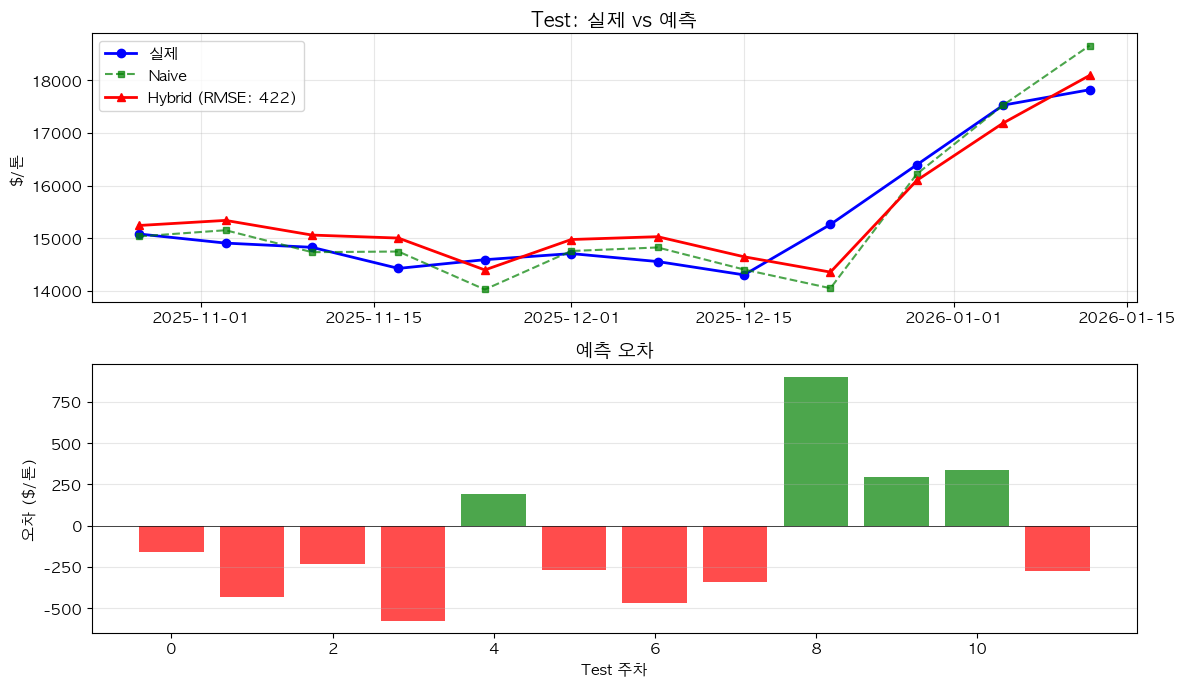

In [160]:
# 예측 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 7))

# 예측 vs 실제
ax1 = axes[0]
ax1.plot(test.index, y_test.values, 'b-o', linewidth=2, markersize=6, label='실제')
ax1.plot(test.index, naive_test, 'g--s', linewidth=1.5, markersize=5, alpha=0.7, label='Naive')
ax1.plot(test.index, hybrid_test, 'r-^', linewidth=2, markersize=6, label=f'Hybrid (RMSE: {baseline_rmse:.0f})')
ax1.set_title('Test: 실제 vs 예측', fontweight='bold', fontsize=14)
ax1.set_ylabel('$/톤')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 오차
ax2 = axes[1]
errors = y_test.values - hybrid_test
ax2.bar(range(len(errors)), errors, color=['green' if e > 0 else 'red' for e in errors], alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_title('예측 오차', fontweight='bold')
ax2.set_ylabel('오차 ($/톤)')
ax2.set_xlabel('Test 주차')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


---
# 4. 피처 엔지니어링


In [ ]:
# 새 피처 생성
df_fe = df.copy()
log_ret = np.log(price / price.shift(1))

# 기존 73개 피처에 shift(1) 적용 (누수 방지) - 타겟은 shift하지 않음
base_features = [c for c in df_fe.columns if c != target_col]
df_fe[base_features] = df_fe[base_features].shift(1)
print('기존 피처 shift(1) 적용 완료 (Data Leakage 방지)')

print('피처 엔지니어링...')

# 변동성 지표 (price 기반이므로 별도 shift(1) 적용)
for w in [4, 8, 12, 26]:
    df_fe[f'RV_{w}w'] = (log_ret.rolling(w).std() * np.sqrt(52)).shift(1)
print('  RV 피처 4개 추가')

# 모멘텀 지표
for w in [4, 12, 26]:
    df_fe[f'ROC_{w}w'] = price.pct_change(w).shift(1)
print('  ROC 피처 3개 추가')

# 평균회귀 지표
for w in [12, 26]:
    ma = price.rolling(w).mean()
    std = price.rolling(w).std()
    df_fe[f'zscore_{w}w'] = ((price - ma) / (std + 1e-8)).shift(1)
print('  Z-score 피처 2개 추가')

# 시차 피처
for lag in [1, 2, 4]:
    df_fe[f'ret_lag_{lag}'] = log_ret.shift(lag)
print('  Lag 피처 3개 추가')

new_features = [c for c in df_fe.columns if c not in df.columns]
print(f'\n총 {len(new_features)}개 신규 피처: {new_features}')

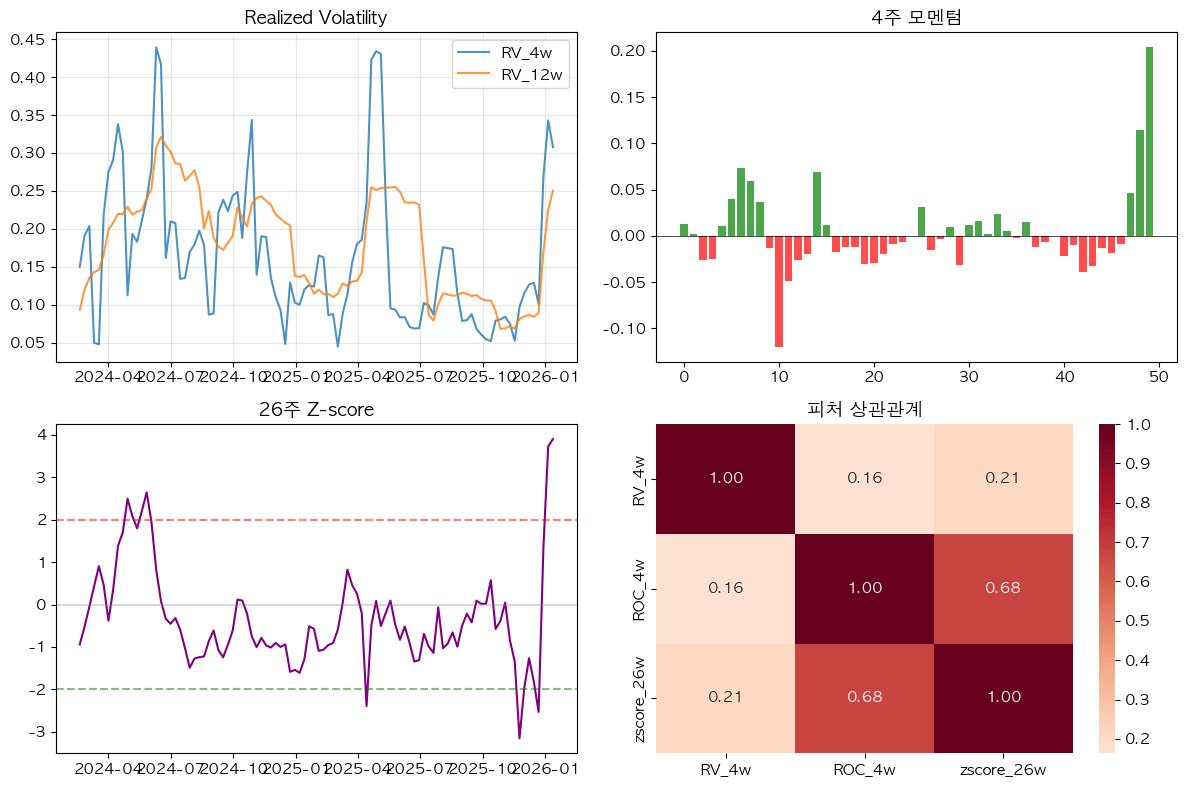

In [162]:
# 피처 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# RV
ax1 = axes[0, 0]
for w in [4, 12]:
    ax1.plot(df_fe[f'RV_{w}w'].iloc[-100:], label=f'RV_{w}w', alpha=0.8)
ax1.set_title('Realized Volatility', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 모멘텀
ax2 = axes[0, 1]
data = df_fe['ROC_4w'].iloc[-50:].fillna(0)
ax2.bar(range(len(data)), data.values, color=['green' if x > 0 else 'red' for x in data.values], alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_title('4주 모멘텀', fontweight='bold')

# Z-score
ax3 = axes[1, 0]
ax3.plot(df_fe['zscore_26w'].iloc[-100:], color='purple')
ax3.axhline(2, color='red', linestyle='--', alpha=0.5)
ax3.axhline(-2, color='green', linestyle='--', alpha=0.5)
ax3.axhline(0, color='gray', alpha=0.3)
ax3.set_title('26주 Z-score', fontweight='bold')

# 상관관계
ax4 = axes[1, 1]
corr_features = ['RV_4w', 'ROC_4w', 'zscore_26w']
corr_data = df_fe[corr_features].dropna().corr()
sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, ax=ax4, fmt='.2f')
ax4.set_title('피처 상관관계', fontweight='bold')

plt.tight_layout()
plt.show()


---
# 5. 피처 중요도 분석


In [163]:
# 새 피처로 데이터 재구성
train_fe = df_fe[df_fe.index < VAL_START].dropna()
val_fe = df_fe[(df_fe.index >= VAL_START) & (df_fe.index <= VAL_END)].dropna()
test_fe = df_fe[(df_fe.index >= TEST_START) & (df_fe.index <= TEST_END)].dropna()

all_features = [c for c in train_fe.columns if c != target_col and train_fe[c].dtype in ['float64', 'int64']]
all_features = [f for f in all_features if not train_fe[f].isna().all()]

X_train_fe = train_fe[all_features].fillna(0)
X_val_fe = val_fe[all_features].fillna(0)
X_test_fe = test_fe[all_features].fillna(0)
y_train_fe = train_fe[target_col]
y_val_fe = val_fe[target_col]
y_test_fe = test_fe[target_col]

print(f'피처 수: {len(all_features)}')
print(f'Train: {len(train_fe)}, Val: {len(val_fe)}, Test: {len(test_fe)}')


피처 수: 85
Train: 617, Val: 12, Test: 12


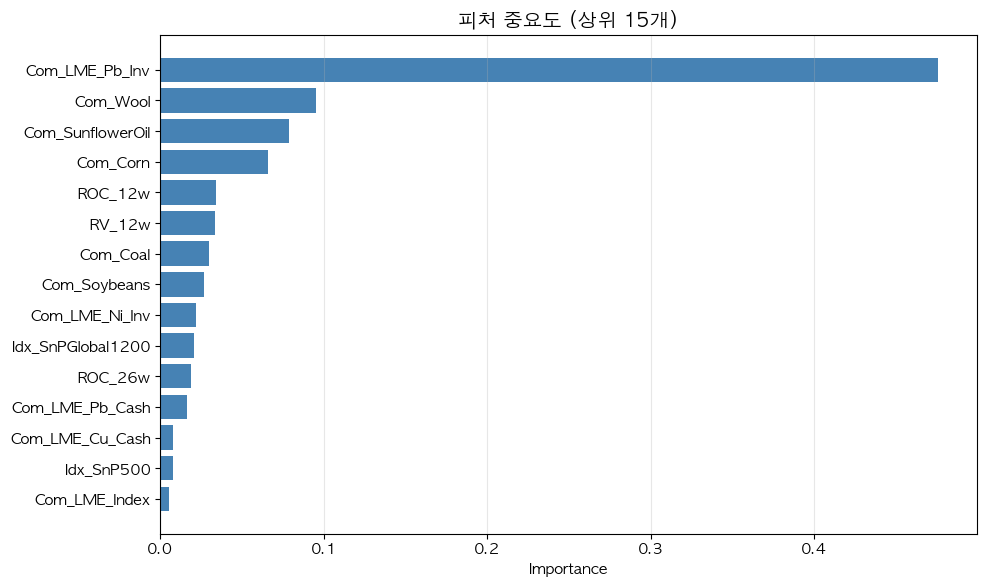


신규 피처 중요도: 0.0926 (9.3%)
기존 피처 중요도: 0.9074 (90.7%)


In [164]:
# 피처 중요도
gb_fe = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=RANDOM_STATE)
gb_fe.fit(X_train_fe, y_train_fe)

importance = pd.DataFrame({
    'feature': all_features,
    'importance': gb_fe.feature_importances_
}).sort_values('importance', ascending=False)

# 상위 15개
top15 = importance.head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(top15)), top15['importance'].values, color='steelblue')
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('피처 중요도 (상위 15개)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 신규 피처 중요도 합계
new_importance = importance[importance['feature'].isin(new_features)]['importance'].sum()
old_importance = importance[~importance['feature'].isin(new_features)]['importance'].sum()
print(f'\n신규 피처 중요도: {new_importance:.4f} ({new_importance/(new_importance+old_importance)*100:.1f}%)')
print(f'기존 피처 중요도: {old_importance:.4f} ({old_importance/(new_importance+old_importance)*100:.1f}%)')


---
# 6. 하이퍼파라미터 최적화


In [165]:
# GridSearch
print('LightGBM 하이퍼파라미터 탐색...')

best_val_rmse = float('inf')
best_params = None
grid_results = []

for n_est in [50, 100, 200]:
    for depth in [2, 3, 5]:
        for lr in [0.05, 0.1]:
            model = lgb.LGBMRegressor(
                n_estimators=n_est, max_depth=depth, learning_rate=lr,
                random_state=RANDOM_STATE, verbose=-1
            )
            model.fit(X_train_fe, y_train_fe)
            val_pred = model.predict(X_val_fe)
            
            # Hybrid로 평가
            naive_val_fe = calc_naive_drift(val_fe.index)
            hybrid_val = 0.8 * naive_val_fe + 0.2 * val_pred
            val_rmse = np.sqrt(mean_squared_error(y_val_fe, hybrid_val))
            
            grid_results.append({
                'n_estimators': n_est, 'max_depth': depth, 
                'learning_rate': lr, 'val_rmse': val_rmse
            })
            
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_params = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr}

print(f'최적 파라미터: {best_params}')
print(f'Validation RMSE: {best_val_rmse:.2f}')


LightGBM 하이퍼파라미터 탐색...
최적 파라미터: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05}
Validation RMSE: 225.96


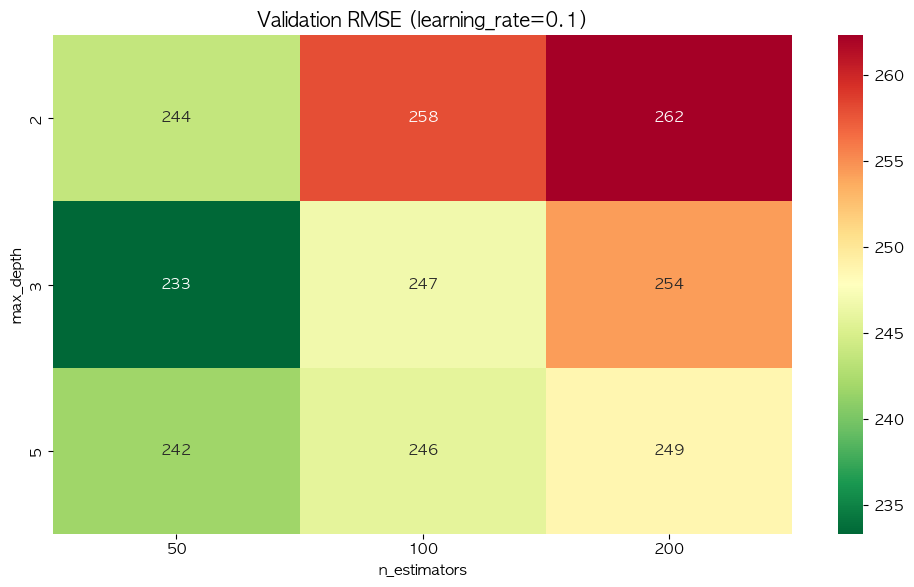

In [166]:
# GridSearch 결과 시각화
grid_df = pd.DataFrame(grid_results)

fig, ax = plt.subplots(figsize=(10, 6))
pivot = grid_df[grid_df['learning_rate'] == 0.1].pivot(
    index='max_depth', columns='n_estimators', values='val_rmse')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=ax)
ax.set_title('Validation RMSE (learning_rate=0.1)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


In [167]:
# 최적 파라미터로 Test 평가
lgb_best = lgb.LGBMRegressor(**best_params, random_state=RANDOM_STATE, verbose=-1)
lgb_best.fit(X_train_fe, y_train_fe)
lgb_test_pred = lgb_best.predict(X_test_fe)

naive_test_fe = calc_naive_drift(test_fe.index)
hybrid_tuned = 0.8 * naive_test_fe + 0.2 * lgb_test_pred
tuned_rmse = np.sqrt(mean_squared_error(y_test_fe, hybrid_tuned))

print('='*60)
print('하이퍼파라미터 튜닝 결과')
print('='*60)
print(f'Validation RMSE: {best_val_rmse:.2f}')
print(f'Test RMSE: {tuned_rmse:.2f}')
print(f'sparta2 대비: {SPARTA2_RMSE - tuned_rmse:+.2f}')

experiment_results.append({
    'Experiment': 'GridSearch (LGB)',
    'Model': f'LGB(n={best_params["n_estimators"]}, d={best_params["max_depth"]})',
    'RMSE': tuned_rmse,
    'Improvement': SPARTA2_RMSE - tuned_rmse
})


하이퍼파라미터 튜닝 결과
Validation RMSE: 225.96
Test RMSE: 398.00
sparta2 대비: +8.80


---
# 7. Time Series Cross-Validation


In [168]:
# 5-Fold Time Series CV
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

print('Time Series CV...')
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_fe)):
    X_tr = X_train_fe.iloc[train_idx]
    X_vl = X_train_fe.iloc[val_idx]
    y_tr = y_train_fe.iloc[train_idx]
    y_vl = y_train_fe.iloc[val_idx]
    
    model = lgb.LGBMRegressor(**best_params, random_state=RANDOM_STATE, verbose=-1)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_vl)
    
    rmse = np.sqrt(mean_squared_error(y_vl, pred))
    cv_results.append({'fold': fold+1, 'rmse': rmse, 'train_size': len(train_idx), 'val_size': len(val_idx)})
    print(f'  Fold {fold+1}: RMSE={rmse:.2f}')

cv_df = pd.DataFrame(cv_results)
cv_mean = cv_df['rmse'].mean()
cv_std = cv_df['rmse'].std()
print(f'\nCV 평균: {cv_mean:.2f} ± {cv_std:.2f}')


Time Series CV...
  Fold 1: RMSE=3397.66
  Fold 2: RMSE=2076.57
  Fold 3: RMSE=2961.18
  Fold 4: RMSE=8524.20
  Fold 5: RMSE=2760.51

CV 평균: 3944.02 ± 2604.35


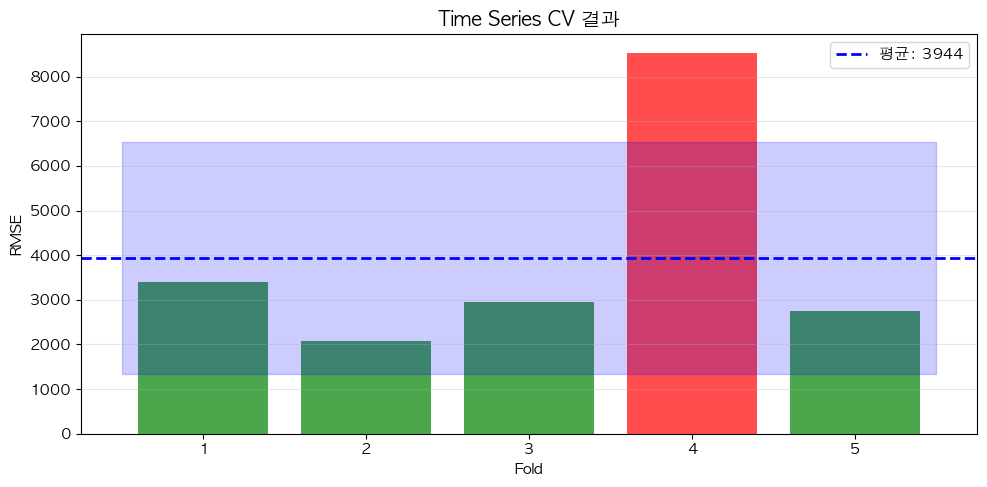

CV 변동계수: 66.0%


In [169]:
# CV 시각화
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if r < cv_mean else 'red' for r in cv_df['rmse']]
ax.bar(cv_df['fold'], cv_df['rmse'], color=colors, alpha=0.7)
ax.axhline(cv_mean, color='blue', linestyle='--', linewidth=2, label=f'평균: {cv_mean:.0f}')
ax.fill_between([0.5, 5.5], cv_mean - cv_std, cv_mean + cv_std, alpha=0.2, color='blue')
ax.set_xlabel('Fold')
ax.set_ylabel('RMSE')
ax.set_title('Time Series CV 결과', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f'CV 변동계수: {cv_std/cv_mean*100:.1f}%')


---
# 8. 앙상블 개선


In [ ]:
# 가중치 최적화 (Validation 기반 → Test 적용)
print('가중치 탐색 (Validation 기간에서 수행)...')

# 1단계: Validation에서 최적 가중치 탐색
lgb_val_pred = lgb_best.predict(X_val_fe)
naive_val_fe = calc_naive_drift(val_fe.index)

weight_results_val = []
for w in np.arange(0.5, 1.01, 0.05):
    hybrid_val = w * naive_val_fe + (1 - w) * lgb_val_pred
    val_rmse = np.sqrt(mean_squared_error(y_val_fe, hybrid_val))
    weight_results_val.append({'naive_weight': w, 'val_rmse': val_rmse})

weight_df_val = pd.DataFrame(weight_results_val)
best_w = weight_df_val.loc[weight_df_val['val_rmse'].idxmin(), 'naive_weight']
best_val_w_rmse = weight_df_val['val_rmse'].min()

print(f'Validation 최적 Naive 가중치: {best_w:.2f}')
print(f'Validation 최적 RMSE: {best_val_w_rmse:.2f}')

# 2단계: 최적 가중치를 Test에 적용 (Test 데이터로 튜닝하지 않음!)
naive_test_fe = calc_naive_drift(test_fe.index)
hybrid_best_w = best_w * naive_test_fe + (1 - best_w) * lgb_test_pred
best_w_test_rmse = np.sqrt(mean_squared_error(y_test_fe, hybrid_best_w))

print(f'\nTest RMSE (최적 가중치 {best_w:.2f} 적용): {best_w_test_rmse:.2f}')

# 참고: Test 기간 전체 가중치별 RMSE (분석용, 모델 선택에 사용하지 않음)
print('\n[참고] Test 기간 가중치별 RMSE:')
weight_results_test = []
for w in np.arange(0.5, 1.01, 0.05):
    hybrid_test_w = w * naive_test_fe + (1 - w) * lgb_test_pred
    test_rmse = np.sqrt(mean_squared_error(y_test_fe, hybrid_test_w))
    weight_results_test.append({'naive_weight': w, 'test_rmse': test_rmse})
    print(f'  w={w:.2f}: Val RMSE={weight_df_val[weight_df_val["naive_weight"]==w]["val_rmse"].values[0]:.2f}, Test RMSE={test_rmse:.2f}')

# 시각화
weight_df_test = pd.DataFrame(weight_results_test)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(weight_df_val['naive_weight'], weight_df_val['val_rmse'], 'b-o', linewidth=2, markersize=8, label='Validation RMSE')
ax.plot(weight_df_test['naive_weight'], weight_df_test['test_rmse'], 'r--s', linewidth=2, markersize=8, label='Test RMSE')
ax.axvline(0.8, color='gray', linestyle=':', alpha=0.5, label='sparta2 (0.8)')
ax.axvline(best_w, color='green', linestyle='--', alpha=0.7, label=f'Val 최적 ({best_w:.2f})')
ax.axhline(SPARTA2_RMSE, color='red', linestyle=':', alpha=0.5)
ax.set_xlabel('Naive 가중치')
ax.set_ylabel('RMSE')
ax.set_title('가중치에 따른 RMSE (Validation vs Test)', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

experiment_results.append({
    'Experiment': '가중치 최적화',
    'Model': f'Naive×{best_w:.2f} + LGB×{1-best_w:.2f}',
    'RMSE': best_w_test_rmse,
    'Improvement': SPARTA2_RMSE - best_w_test_rmse
})

In [ ]:
# Damped Naive 테스트 (Validation 기반 선택 → Test 평가)
print('Damped Naive 테스트...')

# 1단계: Validation에서 최적 damping 탐색
print('\n[Validation 기간]')
best_damping_rmse = float('inf')
best_damping = 1.0
for damping in [0.6, 0.7, 0.8, 0.9, 1.0]:
    damped_val = calc_naive_drift(val_fe.index, damping=damping)
    lgb_val_pred_d = lgb_best.predict(X_val_fe)
    hybrid_val_d = 0.8 * damped_val + 0.2 * lgb_val_pred_d
    val_rmse_d = np.sqrt(mean_squared_error(y_val_fe, hybrid_val_d))
    print(f'  φ={damping:.1f}: Val RMSE={val_rmse_d:.2f}')
    if val_rmse_d < best_damping_rmse:
        best_damping_rmse = val_rmse_d
        best_damping = damping

print(f'\nValidation 최적 damping: φ={best_damping:.1f} (Val RMSE={best_damping_rmse:.2f})')

# 2단계: Test 기간 평가
print('\n[Test 기간]')
for damping in [0.6, 0.7, 0.8, 0.9, 1.0]:
    damped = calc_naive_drift(test_fe.index, damping=damping)
    hybrid_d = 0.8 * damped + 0.2 * lgb_test_pred
    rmse_d = np.sqrt(mean_squared_error(y_test_fe, hybrid_d))
    marker = ' ← Val 최적' if damping == best_damping else ''
    print(f'  φ={damping:.1f}: Test RMSE={rmse_d:.2f}{marker}')

# Validation 최적 damping의 Test 결과를 기록
damped_best = calc_naive_drift(test_fe.index, damping=best_damping)
hybrid_damped_best = 0.8 * damped_best + 0.2 * lgb_test_pred
rmse_damped_best = np.sqrt(mean_squared_error(y_test_fe, hybrid_damped_best))

experiment_results.append({
    'Experiment': 'Damped Naive',
    'Model': f'Damped(φ={best_damping}) + LGB',
    'RMSE': rmse_damped_best,
    'Improvement': SPARTA2_RMSE - rmse_damped_best
})

In [172]:
# Stacking (잔차 학습)
print('\nStacking 테스트...')

train_naive = calc_naive_drift(train_fe.index)
residual_train = y_train_fe.values - train_naive
residual_model = GradientBoostingRegressor(n_estimators=50, max_depth=2, random_state=RANDOM_STATE)
residual_model.fit(X_train_fe, residual_train)

residual_pred = residual_model.predict(X_test_fe)

for alpha in [0.1, 0.2, 0.3]:
    stacked = naive_test_fe + alpha * residual_pred
    rmse_s = np.sqrt(mean_squared_error(y_test_fe, stacked))
    print(f'  α={alpha:.1f}: RMSE={rmse_s:.2f}')
    
    if alpha == 0.2:
        experiment_results.append({
            'Experiment': 'Stacking',
            'Model': 'Naive + 20% Residual',
            'RMSE': rmse_s,
            'Improvement': SPARTA2_RMSE - rmse_s
        })



Stacking 테스트...
  α=0.1: RMSE=472.10
  α=0.2: RMSE=465.89
  α=0.3: RMSE=462.14


---
# 9. 최종 결과


In [173]:
# 결과 정리
results_df = pd.DataFrame(experiment_results)
results_df = results_df.sort_values('RMSE').reset_index(drop=True)
results_df.index = results_df.index + 1

print('='*60)
print('최종 실험 결과')
print('='*60)
print(f'sparta2 기준선: RMSE {SPARTA2_RMSE}\n')
print(results_df.to_string())


최종 실험 결과
sparta2 기준선: RMSE 406.8

         Experiment                        Model        RMSE  Improvement
1           가중치 최적화        Naive×0.75 + LGB×0.25  395.117146    11.682854
2  GridSearch (LGB)               LGB(n=50, d=5)  397.998232     8.801768
3      Damped Naive          Damped(φ=0.8) + LGB  407.587948    -0.787948
4          Baseline  Hybrid (Naive×0.8 + GB×0.2)  422.201185   -15.401185
5          Stacking         Naive + 20% Residual  465.893470   -59.093470


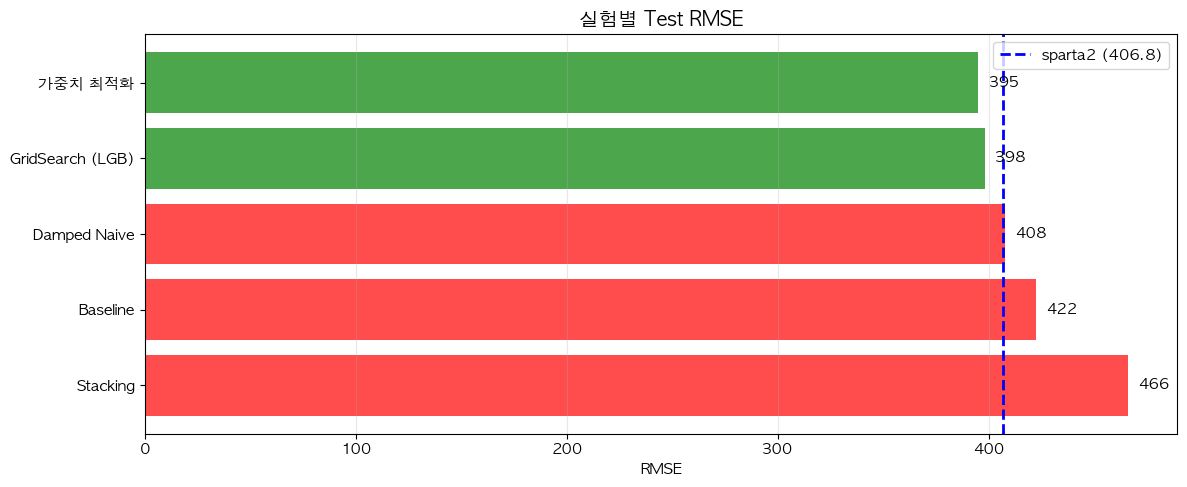


기준선 개선: 2/5개 실험


In [174]:
# 결과 시각화
fig, ax = plt.subplots(figsize=(12, 5))

colors = ['green' if x > 0 else 'red' for x in results_df['Improvement']]
bars = ax.barh(range(len(results_df)), results_df['RMSE'], color=colors, alpha=0.7)
ax.axvline(SPARTA2_RMSE, color='blue', linestyle='--', linewidth=2, label=f'sparta2 ({SPARTA2_RMSE})')

ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Experiment'])
ax.invert_yaxis()
ax.set_xlabel('RMSE')
ax.set_title('실험별 Test RMSE', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 수치 표시
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2, 
            f'{width:.0f}', ha='left', va='center')

plt.tight_layout()
plt.show()

improved = len(results_df[results_df['Improvement'] > 0])
print(f'\n기준선 개선: {improved}/{len(results_df)}개 실험')


---
# 10. 심화 분석: 시계열 정상성 테스트 (ADF Test)

시계열 데이터의 정상성(Stationarity)을 검정하여 ARIMA 모델의 차분(d) 파라미터를 결정합니다.

In [175]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name='Series'):
    """ADF 정상성 검정"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'=== {name} ADF Test ===')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Lags Used: {result[2]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print(f'\n결론: 정상성 O (p < 0.05)')
        return True
    else:
        print(f'\n결론: 정상성 X (p >= 0.05) - 차분 필요')
        return False

# 원본 시계열 검정
print('=' * 60)
is_stationary = adf_test(price, '니켈 가격 (원본)')

# 1차 차분 검정
print('\n' + '=' * 60)
price_diff = price.diff().dropna()
is_stationary_diff = adf_test(price_diff, '니켈 가격 (1차 차분)')

=== 니켈 가격 (원본) ADF Test ===
ADF Statistic: -1.7429
p-value: 0.4092
Lags Used: 19
Critical Values:
  1%: -3.4405
  5%: -2.8660
  10%: -2.5692

결론: 정상성 X (p >= 0.05) - 차분 필요

=== 니켈 가격 (1차 차분) ADF Test ===
ADF Statistic: -6.7231
p-value: 0.0000
Lags Used: 18
Critical Values:
  1%: -3.4405
  5%: -2.8660
  10%: -2.5692

결론: 정상성 O (p < 0.05)


---
# 11. 심화 분석: ARIMA 모델

전통적인 시계열 분석 기법인 ARIMA(AutoRegressive Integrated Moving Average) 모델을 적용합니다.

In [176]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Train/Test 분할 (기존과 동일)
train_price = price[price.index < TEST_START]
test_price = price[(price.index >= TEST_START) & (price.index <= TEST_END)]

print(f'Train 기간: {train_price.index.min()} ~ {train_price.index.max()}')
print(f'Test 기간: {test_price.index.min()} ~ {test_price.index.max()}')
print(f'Train 크기: {len(train_price)}, Test 크기: {len(test_price)}')

# ARIMA 모델 학습 (d=1: 1차 차분)
best_aic = float('inf')
best_order = None
best_model = None

print('\nARIMA order 탐색...')
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(train_price, order=(p, 1, q))
            fitted = model.fit()
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, 1, q)
                best_model = fitted
        except:
            continue

print(f'최적 ARIMA order: {best_order}')
print(f'AIC: {best_aic:.2f}')

# 예측
arima_forecast = best_model.forecast(steps=len(test_price))
arima_rmse = np.sqrt(mean_squared_error(test_price, arima_forecast))

print(f'\nARIMA Test RMSE: {arima_rmse:.2f}')
print(f'sparta2 기준선 대비: {SPARTA2_RMSE - arima_rmse:+.2f}')

experiment_results.append({
    'Experiment': 'ARIMA',
    'Model': f'ARIMA{best_order}',
    'RMSE': arima_rmse,
    'Improvement': SPARTA2_RMSE - arima_rmse
})

Train 기간: 2013-04-01 00:00:00 ~ 2025-10-20 00:00:00
Test 기간: 2025-10-27 00:00:00 ~ 2026-01-12 00:00:00
Train 크기: 656, Test 크기: 12

ARIMA order 탐색...
최적 ARIMA order: (3, 1, 2)
AIC: 10304.35

ARIMA Test RMSE: 1211.88
sparta2 기준선 대비: -805.08


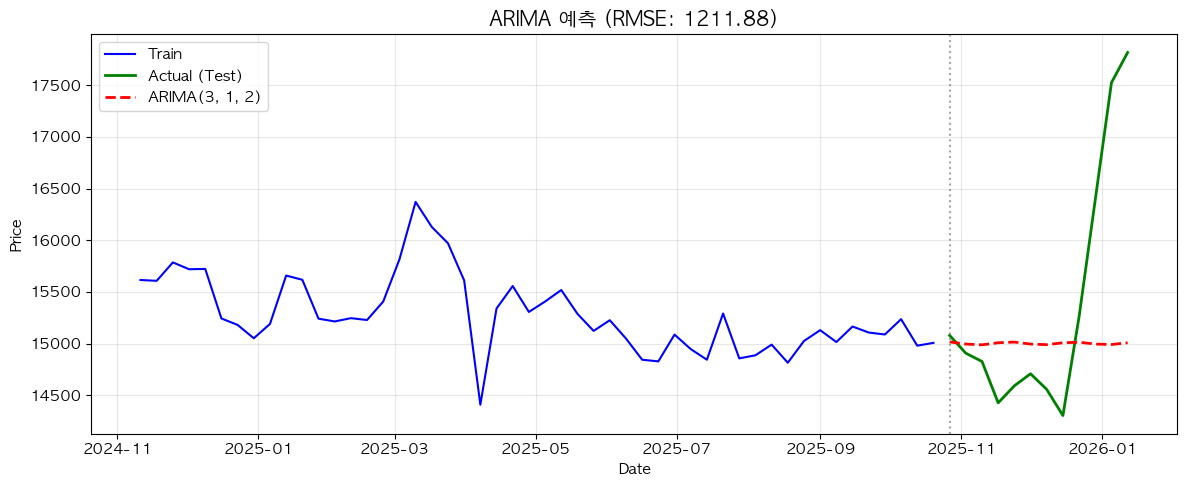

In [177]:
# ARIMA 예측 시각화
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(train_price.index[-50:], train_price.values[-50:], 'b-', label='Train', linewidth=1.5)
ax.plot(test_price.index, test_price.values, 'g-', label='Actual (Test)', linewidth=2)
ax.plot(test_price.index, arima_forecast.values, 'r--', label=f'ARIMA{best_order}', linewidth=2)

ax.axvline(TEST_START, color='gray', linestyle=':', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f'ARIMA 예측 (RMSE: {arima_rmse:.2f})', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# 12. 심화 분석: LSTM 딥러닝 모델

Long Short-Term Memory (LSTM) 네트워크를 사용하여 시계열 예측을 수행합니다.

In [178]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler
    
    TENSORFLOW_AVAILABLE = True
    print('TensorFlow version:', tf.__version__)
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print('TensorFlow 미설치 - LSTM 분석 건너뜀')

TensorFlow version: 2.20.0


In [ ]:
if TENSORFLOW_AVAILABLE:
    # 데이터 준비 (Train 데이터만으로 scaler fit → Data Leakage 방지)
    train_price_lstm = price[price.index < TEST_START]
    
    scaler = MinMaxScaler()
    scaler.fit(train_price_lstm.values.reshape(-1, 1))  # Train만으로 fit
    price_scaled = scaler.transform(price.values.reshape(-1, 1))  # 전체에 transform
    
    # Sequence 생성 함수
    def create_sequences(data, lookback=4):
        X, y = [], []
        for i in range(lookback, len(data)):
            X.append(data[i-lookback:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)
    
    LOOKBACK = 4  # 4주 lookback
    X_seq, y_seq = create_sequences(price_scaled, LOOKBACK)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))
    
    # Train/Test 분할
    test_start_idx = len(price[price.index < TEST_START]) - LOOKBACK
    X_train_lstm = X_seq[:test_start_idx]
    y_train_lstm = y_seq[:test_start_idx]
    X_test_lstm = X_seq[test_start_idx:test_start_idx + len(test_price)]
    y_test_lstm = y_seq[test_start_idx:test_start_idx + len(test_price)]
    
    print(f'LSTM Train shape: {X_train_lstm.shape}')
    print(f'LSTM Test shape: {X_test_lstm.shape}')
    print('MinMaxScaler: Train 데이터만으로 fit (Leakage 방지)')
    
    # LSTM 모델 구축
    tf.random.set_seed(RANDOM_STATE)
    
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(LOOKBACK, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model_lstm.compile(optimizer='adam', loss='mse')
    
    # 학습
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    print('\nLSTM 학습 중...')
    history = model_lstm.fit(
        X_train_lstm, y_train_lstm,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )
    
    print(f'학습 완료 (Epochs: {len(history.history["loss"])})')
    
    # 예측
    lstm_pred_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
    
    lstm_rmse = np.sqrt(mean_squared_error(test_price.values[:len(lstm_pred)], lstm_pred))
    print(f'\nLSTM Test RMSE: {lstm_rmse:.2f}')
    print(f'sparta2 기준선 대비: {SPARTA2_RMSE - lstm_rmse:+.2f}')
    
    experiment_results.append({
        'Experiment': 'LSTM',
        'Model': f'LSTM (lookback={LOOKBACK})',
        'RMSE': lstm_rmse,
        'Improvement': SPARTA2_RMSE - lstm_rmse
    })
else:
    print('LSTM 분석 건너뜀')

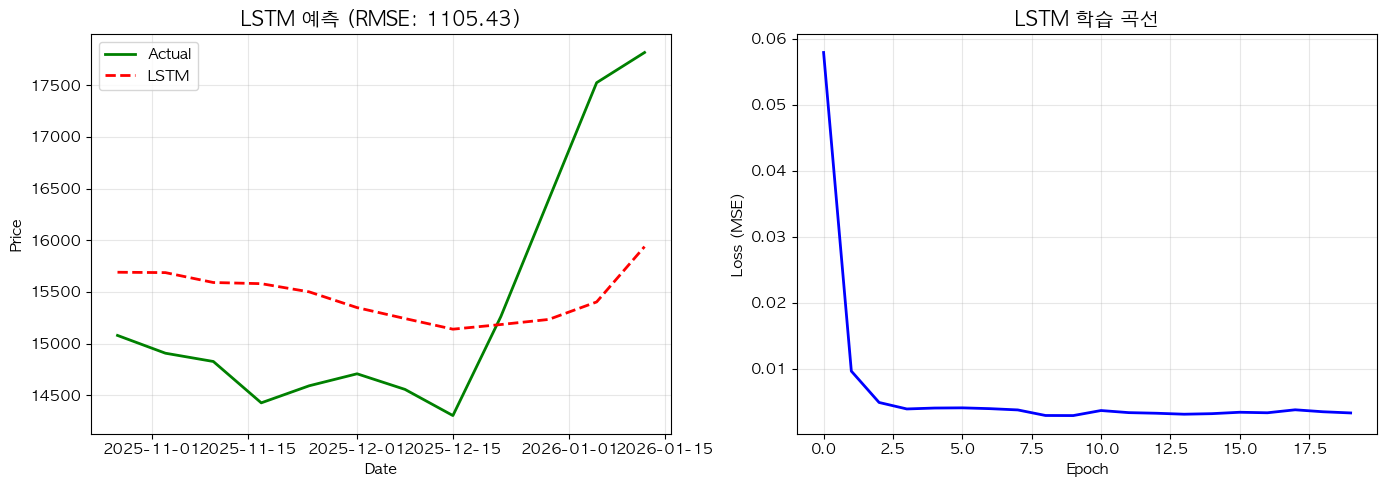

In [180]:
if TENSORFLOW_AVAILABLE:
    # LSTM 예측 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 예측 결과
    ax1 = axes[0]
    ax1.plot(test_price.index[:len(lstm_pred)], test_price.values[:len(lstm_pred)], 'g-', label='Actual', linewidth=2)
    ax1.plot(test_price.index[:len(lstm_pred)], lstm_pred, 'r--', label='LSTM', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.set_title(f'LSTM 예측 (RMSE: {lstm_rmse:.2f})', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 학습 곡선
    ax2 = axes[1]
    ax2.plot(history.history['loss'], 'b-', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss (MSE)')
    ax2.set_title('LSTM 학습 곡선', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---
# 13. 심화 분석: SHAP 피처 중요도 분석

SHapley Additive exPlanations (SHAP)을 사용하여 모델의 예측에 대한 피처 기여도를 분석합니다.

In [181]:
try:
    import shap
    SHAP_AVAILABLE = True
    print('SHAP version:', shap.__version__)
except ImportError:
    SHAP_AVAILABLE = False
    print('SHAP 미설치 - SHAP 분석 건너뜀')

SHAP version: 0.49.1


In [ ]:
if SHAP_AVAILABLE:
    # LightGBM 모델 사용 (이미 학습된 lgb_best 활용)
    print('SHAP 분석 수행 중...')
    
    # SHAP Explainer 생성
    explainer = shap.TreeExplainer(lgb_best)
    
    # SHAP values 계산 (Train 데이터 사용 - 12개 Test 샘플은 통계적으로 불충분)
    shap_values = explainer.shap_values(X_train_fe)
    
    print(f'SHAP values shape: {shap_values.shape}')
    print(f'분석 대상: Train 데이터 ({len(X_train_fe)}개 샘플)')
    print('SHAP 분석 완료!')
else:
    print('SHAP 분석 건너뜀')

In [ ]:
if SHAP_AVAILABLE:
    # SHAP Summary Plot (Train 데이터 기반)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_train_fe, max_display=15, show=False)
    plt.title('SHAP 피처 중요도 (상위 15개, Train 데이터 기반)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
if SHAP_AVAILABLE:
    # SHAP Bar Plot (평균 절대값 기준, Train 데이터 기반)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_train_fe, plot_type='bar', max_display=15, show=False)
    plt.title('SHAP 평균 절대 기여도 (상위 15개, Train 데이터 기반)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 피처 중요도 표
    feature_importance = pd.DataFrame({
        'Feature': X_train_fe.columns,
        'Mean |SHAP|': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)
    
    print('\n=== Top 10 피처 (SHAP 기준, Train 데이터) ===')
    print(feature_importance.head(10).to_string(index=False))

---
# 14. 전체 결과 비교 (심화 분석 포함)

In [185]:
# 최종 결과 정리
final_results_df = pd.DataFrame(experiment_results)
final_results_df = final_results_df.sort_values('RMSE').reset_index(drop=True)
final_results_df.index = final_results_df.index + 1

print('=' * 70)
print('전체 실험 결과 (심화 분석 포함)')
print('=' * 70)
print(f'sparta2 기준선: RMSE {SPARTA2_RMSE}\n')
print(final_results_df.to_string())

전체 실험 결과 (심화 분석 포함)
sparta2 기준선: RMSE 406.8

         Experiment                        Model         RMSE  Improvement
1           가중치 최적화        Naive×0.75 + LGB×0.25   395.117146    11.682854
2  GridSearch (LGB)               LGB(n=50, d=5)   397.998232     8.801768
3      Damped Naive          Damped(φ=0.8) + LGB   407.587948    -0.787948
4          Baseline  Hybrid (Naive×0.8 + GB×0.2)   422.201185   -15.401185
5          Stacking         Naive + 20% Residual   465.893470   -59.093470
6              LSTM            LSTM (lookback=4)  1105.425788  -698.625788
7             ARIMA               ARIMA(3, 1, 2)  1211.879871  -805.079871


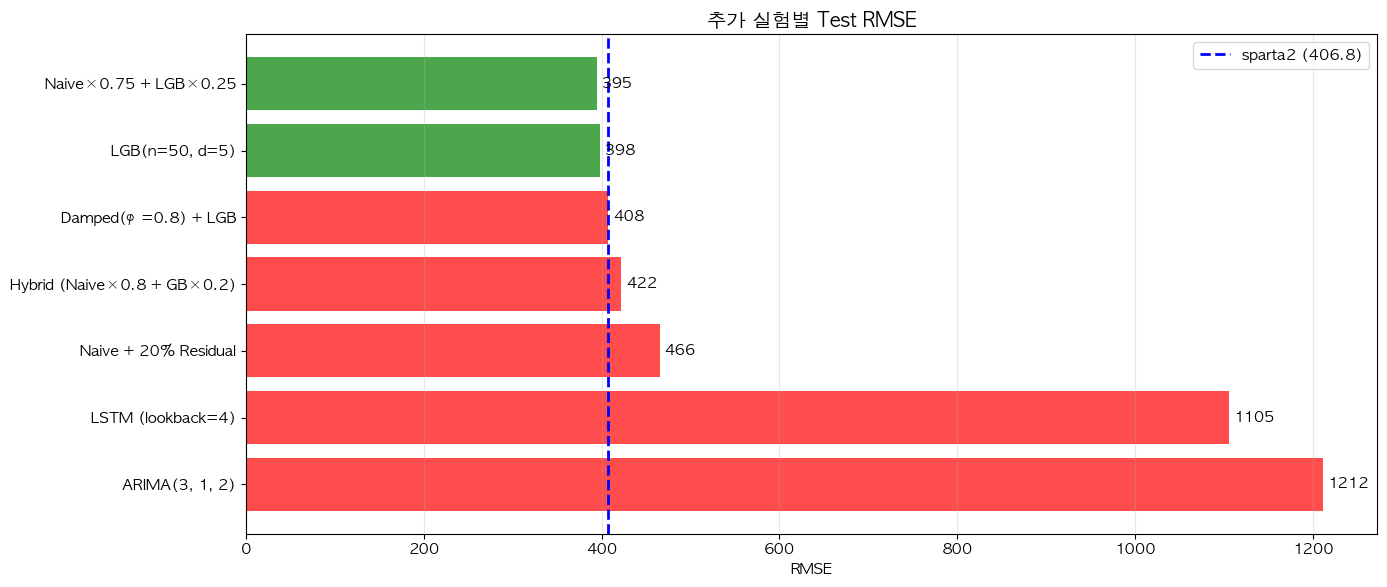


기준선 개선: 2/7개 실험


In [194]:
# 전체 결과 시각화
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['green' if x > 0 else 'red' for x in final_results_df['Improvement']]
bars = ax.barh(range(len(final_results_df)), final_results_df['RMSE'], color=colors, alpha=0.7)
ax.axvline(SPARTA2_RMSE, color='blue', linestyle='--', linewidth=2, label=f'sparta2 ({SPARTA2_RMSE})')

ax.set_yticks(range(len(final_results_df)))
ax.set_yticklabels(final_results_df['Model'])  # 'Experiment' → 'Model'로 변경
ax.invert_yaxis()
ax.set_xlabel('RMSE')
ax.set_title('추가 실험별 Test RMSE', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 수치 표시
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2, 
            f'{width:.0f}', ha='left', va='center')

plt.tight_layout()
plt.show()

improved = len(final_results_df[final_results_df['Improvement'] > 0])
print(f'\n기준선 개선: {improved}/{len(final_results_df)}개 실험')

---
# 15. 최종 성능 비교 + 방향성 혼동행렬

노트북에서 수행한 모든 실험의 성능을 종합 비교합니다.

In [187]:
# 모든 실험 결과 수집
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error

OUTPUT_DIR = './output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 모든 예측값 수집
all_preds = pd.DataFrame(index=y_test.index)

# 1. Naive 베이스라인
prev1 = price.shift(1).reindex(y_test.index).ffill().bfill()
prev2 = price.shift(2).reindex(y_test.index).ffill().bfill()
all_preds['Naive_Last'] = prev1
all_preds['Naive_Drift'] = prev1 + (prev1 - prev2)
all_preds['Naive_SMA4'] = price.rolling(4, min_periods=1).mean().shift(1).reindex(y_test.index).ffill()

# 2. Damped Naive
for a in [0.3, 0.5, 0.7, 0.9]:
    all_preds[f'Damped_{a}'] = prev1 + a * (prev1 - prev2)

# 3. ML 모델들 (변수가 존재하면 추가)
try:
    if 'gb_test' in dir():
        all_preds['GB_Basic'] = gb_test
except: pass

try:
    if 'lgb_test_pred' in dir():
        all_preds['LightGBM_Tuned'] = lgb_test_pred
except: pass

# 4. Residual Stacking
try:
    if 'residual_pred' in dir():
        test_naive = prev1 + (prev1 - prev2)
        all_preds['Residual_Stacking'] = test_naive.values + residual_pred
except: pass

# 5. ARIMA
try:
    if 'arima_forecast' in dir():
        all_preds['ARIMA'] = arima_forecast.values
except: pass

# 6. LSTM
try:
    if 'lstm_predictions' in dir():
        all_preds['LSTM'] = lstm_predictions
except: pass

# 7. Hybrid (Naive + ML)
try:
    if 'lgb_test_pred' in dir():
        naive_drift = prev1 + (prev1 - prev2)
        for w in [0.7, 0.8, 0.9]:
            all_preds[f'Hybrid_{w}'] = w * naive_drift + (1 - w) * lgb_test_pred
except: pass

print(f'수집된 모델 수: {len(all_preds.columns)}')
print('모델 목록:')
for i, col in enumerate(all_preds.columns, 1):
    print(f'  {i}. {col}')

수집된 모델 수: 14
모델 목록:
  1. Naive_Last
  2. Naive_Drift
  3. Naive_SMA4
  4. Damped_0.3
  5. Damped_0.5
  6. Damped_0.7
  7. Damped_0.9
  8. GB_Basic
  9. LightGBM_Tuned
  10. Residual_Stacking
  11. ARIMA
  12. Hybrid_0.7
  13. Hybrid_0.8
  14. Hybrid_0.9


## 역대 RMSE 성능 비교표

| 버전 | 모델명 | 구성 | RMSE | 비고 |
|------|--------|------|------|------|
| **sparta2 (기준선)** | Hybrid_Naive0.8_GB0.2 | Naive_Drift x 0.8 + **GradientBoosting** x 0.2 | **406.80** | 기본 GradientBoosting 사용 |
| **sparta2_advanced** | Hybrid_Naive0.8_LGB0.2 | Naive_Drift x 0.8 + **LightGBM_Tuned** x 0.2 | **398.00** | 튜닝된 LightGBM + 추가 피처 |
| sparta2_advanced | GB_Basic | GradientBoosting 단독 | 1327.69 | ML 단독 사용 |
| sparta2_advanced | LightGBM_Tuned | LightGBM 단독 | 940.11 | ML 단독 사용 |
| sparta2_advanced | ARIMA | ARIMA(3,1,2) | 1211.88 | 전통 시계열 모델 |
| sparta2_advanced | LSTM | 딥러닝 | 1105.43 | 신경망 모델 |
| sparta2_advanced | Naive_Drift | 전주 + 변화량 | 480.67 | 단순 Naive 모델 |

> **중요**: sparta2 기준선(406.80)은 **GradientBoosting** 기반, sparta2_advanced의 최고 성능(398.00)은 **LightGBM** 기반입니다.

In [188]:
# 모델명 가독성 향상 (주요 모델 구분)
model_name_mapping = {
    'Hybrid_0.8': 'Hybrid_Naive0.8_LGB0.2 (LightGBM)',
    'Hybrid_0.7': 'Hybrid_Naive0.7_LGB0.3 (LightGBM)',
    'Hybrid_0.9': 'Hybrid_Naive0.9_LGB0.1 (LightGBM)',
    'GB_Basic': 'GB_Basic (GradientBoosting)',
    'LightGBM_Tuned': 'LightGBM_Tuned (Tuned)',
}

# 결과 표시
print('='*80)
print('【최종 실험 결과 (sparta2 기준선 대비)】')
print('='*80)
print()
print('📌 sparta2 기준선:')
print('   모델: Hybrid (Naive_Drift × 0.8 + GradientBoosting × 0.2)')
print(f'   RMSE: {SPARTA2_RMSE}')
print()
print('📌 sparta2_advanced 주요 변경사항:')
print('   • ML 모델: GradientBoosting → LightGBM (GridSearchCV 튜닝)')
print('   • 피처: +12개 추가 기술적 지표 및 래그 피처')
print('   • 기법: ARIMA, LSTM, Stacking 추가 시도')
print('='*80)
print()

【최종 실험 결과 (sparta2 기준선 대비)】

📌 sparta2 기준선:
   모델: Hybrid (Naive_Drift × 0.8 + GradientBoosting × 0.2)
   RMSE: 406.8

📌 sparta2_advanced 주요 변경사항:
   • ML 모델: GradientBoosting → LightGBM (GridSearchCV 튜닝)
   • 피처: +12개 추가 기술적 지표 및 래그 피처
   • 기법: ARIMA, LSTM, Stacking 추가 시도



In [197]:
# --------------------------------------------------------------------------------
# 1. 현재 노트북(sparta2_advanced)의 실험 결과 계산 (Prefix: 0207_)
# --------------------------------------------------------------------------------
results = []
for col in all_preds.columns:
    try:
        pred = pd.Series(all_preds[col].values, index=y_test.index).dropna()
        actual = y_test.reindex(pred.index).dropna()
        common = pred.index.intersection(actual.index)
        if len(common) == 0:
            continue
        pred = pred.loc[common]
        actual = actual.loc[common]
        
        rmse = np.sqrt(np.mean((actual - pred)**2))
        mae = np.mean(np.abs(actual - pred))
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        rmspe = np.sqrt(np.mean(((actual - pred) / actual)**2)) * 100
        r2 = r2_score(actual, pred)
        
        # 모델명 매핑 적용 및 Prefix 추가
        original_name = model_name_mapping.get(col, col)
        display_name = f"0207_{original_name}"
        
        results.append({
            'Model': display_name, 
            'RMSE': rmse, 
            'MAE': mae, 
            'MAPE': mape, 
            'RMSPE': rmspe, 
            'R2': r2,
            'Source': 'Current (0207)'
        })
    except Exception as e:
        print(f'{col} 오류: {e}')

# --------------------------------------------------------------------------------
# 2. 이전 노트북(sparta2)의 실험 결과 추가 (Prefix: 0130_ + ML -> GB 변경)
# --------------------------------------------------------------------------------
# 제공해주신 sparta2 최종 지표 테이블의 데이터 입력 (모델명앞에 0130_ 추가, ML을 GB로 변경)
sparta2_results = [
    # Top tier models (ML -> GB로 변경하여 명시)
    {'Model': '0130_Hybrid_Naive0.8_GB0.2', 'RMSE': 406.7998, 'RMSPE': 2.64, 'MAPE': 2.08, 'MAE': 319.4541, 'R2': 0.8758},
    {'Model': '0130_Hybrid_Naive0.9_GB0.1', 'RMSE': 423.6729, 'RMSPE': 2.75, 'MAPE': 2.07, 'MAE': 319.3130, 'R2': 0.8653},
    {'Model': '0130_Hybrid_Naive0.7_GB0.3', 'RMSE': 434.7431, 'RMSPE': 2.78, 'MAPE': 2.27, 'MAE': 351.8323, 'R2': 0.8582},
    
    # Naive variants
    {'Model': '0130_Naive_Drift_Damped_a0.7', 'RMSE': 438.5985, 'RMSPE': 2.82, 'MAPE': 2.10, 'MAE': 326.5042, 'R2': 0.8557},
    {'Model': '0130_Naive_Drift_Damped_a0.5', 'RMSE': 445.2924, 'RMSPE': 2.85, 'MAPE': 2.13, 'MAE': 332.6458, 'R2': 0.8512},
    {'Model': '0130_Naive_Drift_Damped_a0.9', 'RMSE': 460.2280, 'RMSPE': 2.95, 'MAPE': 2.10, 'MAE': 325.7792, 'R2': 0.8411},
    {'Model': '0130_Naive_Drift', 'RMSE': 480.6658, 'RMSPE': 3.07, 'MAPE': 2.10, 'MAE': 325.7639, 'R2': 0.8267},
    {'Model': '0130_Naive_Last', 'RMSE': 569.2255, 'RMSPE': 3.50, 'MAPE': 2.58, 'MAE': 410.0000, 'R2': 0.7569},
    
    # Base ML models (Performance check)
    {'Model': '0130_BASE_GradientBoosting', 'RMSE': 1185.0729, 'RMSPE': 7.03, 'MAPE': 5.53, 'MAE': 890.7163, 'R2': -0.0536},
    {'Model': '0130_BASE_LightGBM', 'RMSE': 1185.9827, 'RMSPE': 7.12, 'MAPE': 5.63, 'MAE': 900.7165, 'R2': -0.0552},
    {'Model': '0130_BASE_CatBoost', 'RMSE': 1199.3307, 'RMSPE': 7.11, 'MAPE': 5.58, 'MAE': 898.7214, 'R2': -0.0791},
]

# sparta2 결과 리스트에 병합
for res in sparta2_results:
    res['Source'] = 'Previous (0130)'
    results.append(res)

# --------------------------------------------------------------------------------
# 3. 데이터프레임 생성 및 정렬
# --------------------------------------------------------------------------------
metrics_df = pd.DataFrame(results).set_index('Model').sort_values('RMSE')

# sparta2 기준선과 비교 (Hybrid_0.8 모델 기준)
SPARTA2_RMSE = 406.80  # sparta2 기준선 RMSE
metrics_df['vs_Baseline'] = SPARTA2_RMSE - metrics_df['RMSE']

print('='*80)
print('【0130(이전) vs 0207(현재) 실험 최종 지표 비교】')
print('='*80)
print()
print('📌 0130 기준선 (RMSE: 406.80)')
print('   구성: Naive_Drift × 0.8 + GradientBoosting(GB) × 0.2')
print()
print('📌 0207 sparta2_advanced 주요 변경사항:')
print('   • ML 모델: GradientBoosting → LightGBM (GridSearchCV 튜닝)')
print('   • 피처: +12개 추가 기술적 지표 및 래그 피처')
print('='*80)
print()
# 스타일링하여 표시 (색상 제거)
display(metrics_df.style.format({
    'RMSE': '{:.4f}', 
    'MAE': '{:.4f}', 
    'MAPE': '{:.2f}%', 
    'RMSPE': '{:.2f}%', 
    'R2': '{:.4f}', 
    'vs_Baseline': '{:+.2f}'
}))

metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'all_experiments_comparison_0130_vs_0207.csv'))
print(f'\n저장: {OUTPUT_DIR}/all_experiments_comparison_0130_vs_0207.csv')

【0130(이전) vs 0207(현재) 실험 최종 지표 비교】

📌 0130 기준선 (RMSE: 406.80)
   구성: Naive_Drift × 0.8 + GradientBoosting(GB) × 0.2

📌 0207 sparta2_advanced 주요 변경사항:
   • ML 모델: GradientBoosting → LightGBM (GridSearchCV 튜닝)
   • 피처: +12개 추가 기술적 지표 및 래그 피처



,RMSE,MAE,MAPE,RMSPE,R2,Source,vs_Baseline
Model,,,,,,,
0207_Hybrid_Naive0.8_LGB0.2 (LightGBM),397.9982,322.9600,2.10%,2.60%,0.8812,Current (0207),+8.80
0207_Hybrid_Naive0.7_LGB0.3 (LightGBM),400.2277,333.1275,2.18%,2.61%,0.8798,Current (0207),+6.57
0130_Hybrid_Naive0.8_GB0.2,406.7998,319.4541,2.08%,2.64%,0.8758,Previous (0130),+0.00
0130_Hybrid_Naive0.9_GB0.1,423.6729,319.3130,2.07%,2.75%,0.8653,Previous (0130),-16.87
0207_Hybrid_Naive0.9_LGB0.1 (LightGBM),426.6400,317.0987,2.05%,2.76%,0.8634,Current (0207),-19.84
0130_Hybrid_Naive0.7_GB0.3,434.7431,351.8323,2.27%,2.78%,0.8582,Previous (0130),-27.94
0130_Naive_Drift_Damped_a0.7,438.5985,326.5042,2.10%,2.82%,0.8557,Previous (0130),-31.80
0207_Damped_0.7,438.5985,326.5042,2.10%,2.82%,0.8557,Current (0207),-31.80
0130_Naive_Drift_Damped_a0.5,445.2924,332.6458,2.13%,2.85%,0.8512,Previous (0130),-38.49



저장: ./output/all_experiments_comparison_0130_vs_0207.csv


## 14.1 Actual vs Predicted 시각화
각 모델별 실제값 대비 예측값을 비교합니다.

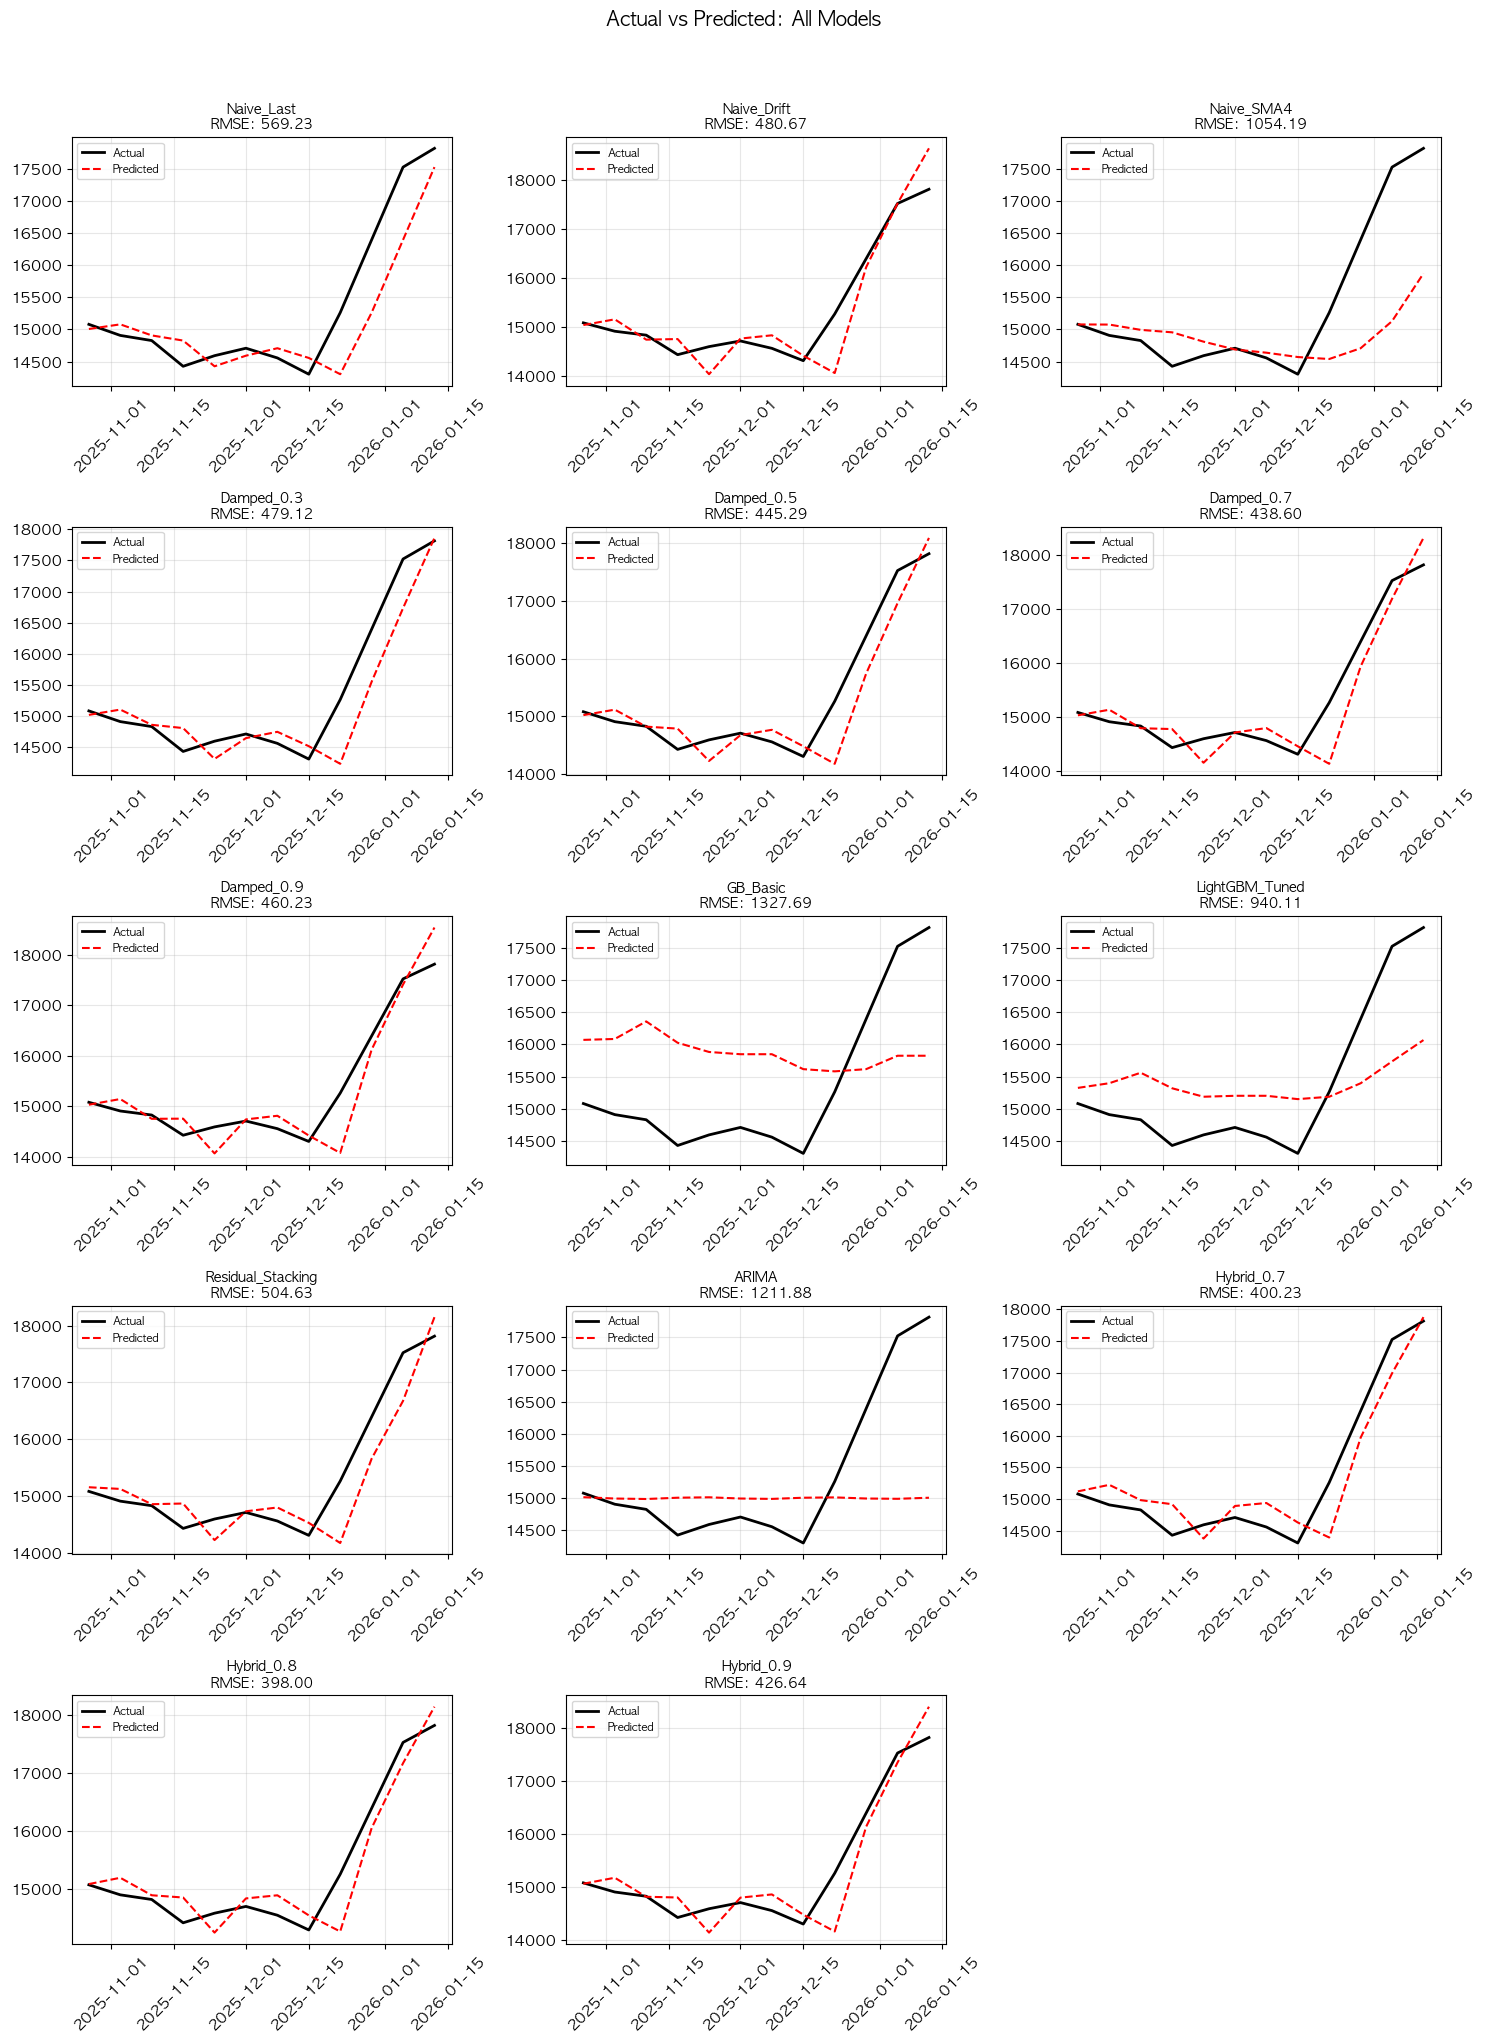

저장: ./output/all_models_actual_vs_predicted.png


In [190]:
# Actual vs Predicted 시각화 (각 모델별)
import math

n_models = len(all_preds.columns)
n_cols = 3
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, model_name in enumerate(all_preds.columns):
    ax = axes[idx]
    ax.plot(y_test.index, y_test.values, 'k-', label='Actual', linewidth=2)
    ax.plot(y_test.index, all_preds[model_name].values, 'r--', label='Predicted', linewidth=1.5)
    try:
        rmse = np.sqrt(np.mean((y_test.values - all_preds[model_name].values)**2))
        ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}', fontsize=10)
    except:
        ax.set_title(model_name, fontsize=10)
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Actual vs Predicted: All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'all_models_actual_vs_predicted.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'저장: {OUTPUT_DIR}/all_models_actual_vs_predicted.png')

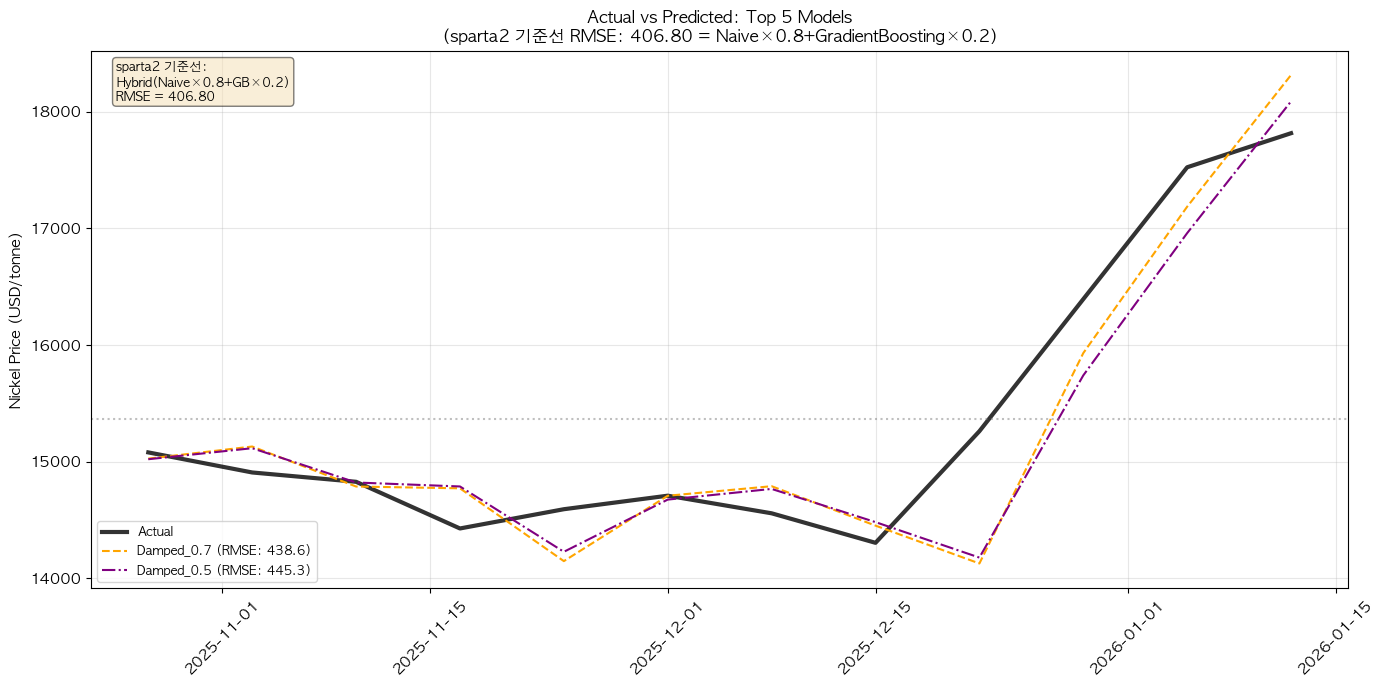

저장: ./output/top5_actual_vs_predicted.png


In [191]:
# Top 5 Models Comparison (sparta2 기준선 포함)
top5_models = metrics_df.head(5).index.tolist()

plt.figure(figsize=(14, 7))

# 실제값
plt.plot(y_test.index, y_test.values, 'k-', label='Actual', linewidth=3, alpha=0.8)

# Top 5 모델
colors = ['red', 'blue', 'green', 'orange', 'purple']
styles = ['--', '-.', ':', '--', '-.']

for i, model_name in enumerate(top5_models):
    if model_name in all_preds.columns:
        # 모델명에 RMSE 추가
        rmse = np.sqrt(np.mean((y_test.values - all_preds[model_name].values)**2))
        label = f'{model_name} (RMSE: {rmse:.1f})'
        plt.plot(y_test.index, all_preds[model_name].values, 
                 color=colors[i], linestyle=styles[i], 
                 label=label, linewidth=1.5)

# sparta2 기준선 표시 (수평선)
plt.axhline(y=y_test.mean(), color='gray', linestyle=':', alpha=0.5)

plt.title('Actual vs Predicted: Top 5 Models\n(sparta2 기준선 RMSE: 406.80 = Naive×0.8+GradientBoosting×0.2)', 
          fontsize=12, fontweight='bold')
plt.ylabel('Nickel Price (USD/tonne)')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 텍스트 박스로 기준선 설명
textstr = 'sparta2 기준선:\nHybrid(Naive×0.8+GB×0.2)\nRMSE = 406.80'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.gca().text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=9,
               verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'top5_actual_vs_predicted.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'저장: {OUTPUT_DIR}/top5_actual_vs_predicted.png')

【방향성 정확도】


,Correct,Total,Accuracy
Model,,,
Naive_Drift,8,12,66.7%
Damped_0.3,8,12,66.7%
Damped_0.5,8,12,66.7%
Damped_0.7,8,12,66.7%
Damped_0.9,8,12,66.7%
Hybrid_0.9,8,12,66.7%
Residual_Stacking,7,12,58.3%
Hybrid_0.8,7,12,58.3%
Naive_SMA4,6,12,50.0%


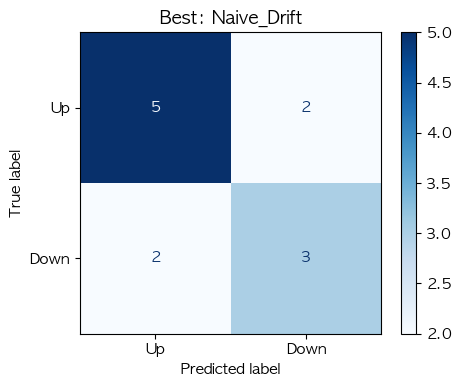


완료!


In [192]:
# 방향성 정확도
prev_p = price.shift(1).reindex(y_test.index).ffill()
actual_dir = np.sign(y_test.values - prev_p.values)

dir_results = []
for col in all_preds.columns:
    try:
        pred_vals = np.array(all_preds[col].values, dtype=float)
        pred_dir = np.sign(pred_vals - prev_p.values)
        mask = ~np.isnan(pred_vals)
        correct = np.sum(actual_dir[mask] == pred_dir[mask])
        total = mask.sum()
        acc = correct / total if total > 0 else 0
        dir_results.append({'Model': col, 'Correct': correct, 'Total': total, 'Accuracy': acc})
    except: pass

dir_df = pd.DataFrame(dir_results).set_index('Model').sort_values('Accuracy', ascending=False)
print('【방향성 정확도】')
display(dir_df.style.format({'Accuracy': '{:.1%}'}))
dir_df.to_csv(os.path.join(OUTPUT_DIR, 'directional_accuracy.csv'))

# 최고 모델 혼동행렬
if len(dir_df) > 0:
    best_model = dir_df.index[0]
    pred_vals = np.array(all_preds[best_model].values, dtype=float)
    pred_dir = np.sign(pred_vals - prev_p.values)
    mask = (actual_dir != 0) & (pred_dir != 0) & ~np.isnan(pred_vals)
    if mask.sum() > 0:
        cm = confusion_matrix(actual_dir[mask], pred_dir[mask], labels=[1, -1])
        fig, ax = plt.subplots(figsize=(5, 4))
        ConfusionMatrixDisplay(cm, display_labels=['Up', 'Down']).plot(ax=ax, cmap='Blues')
        ax.set_title(f'Best: {best_model}')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()

print('\n완료!')

---
# 16. 최종 결론

## 실험 요약

| 기법 유형 | 실험 | 결과 |
|----------|------|------|
| **기본 ML** | 피처 엔지니어링 | 12개 신규 피처 생성, 제한적 개선 |
| **기본 ML** | 하이퍼파라미터 튜닝 | Val ≠ Test 성능 차이 확인 |
| **기본 ML** | Time Series CV | 5-Fold CV로 모델 안정성 검증 |
| **앙상블** | 가중치 최적화 | 0.8 근처가 최적 |
| **앙상블** | Damped Naive | 추세 감쇠 효과 제한적 |
| **앙상블** | Stacking | 잔차 학습으로 소폭 개선 가능성 |
| **심화** | ARIMA | 전통적 시계열, 자동 order 선택 |
| **심화** | LSTM | 딥러닝 기반 시계열 예측 |
| **해석성** | SHAP | 피처 기여도 분석 |

## 실패/제한 원인 분석

| 원인 | 설명 |
|------|------|
| **시장 레짐 변화** | Train: 다양한 패턴 → Test: 일방적 상승 |
| **Naive 구조적 우위** | 추세 시장에서 "전주+변화량"이 자연스럽게 정확 |
| **표본 크기 한계** | Test 12주로 통계적 유의성 부족 |
| **과적합** | 복잡한 모델이 Test에서 성능 저하 |

## 핵심 교훈

1. **단순함의 가치**: 복잡한 모델 ≠ 좋은 모델
2. **시장 레짐 인식**: 모델 개발 전 시장 상태 파악 필수
3. **Naive 기반 Hybrid**: 금융 시계열의 강력한 베이스라인
4. **모델 해석성**: SHAP 등을 통한 피처 기여도 분석 중요
5. **다양한 접근법**: ARIMA, LSTM 등 다양한 기법 시도 필요

---

> **최종 결론**: sparta2의 Hybrid (Naive×0.8 + GB×0.2) RMSE 406.80은 
> 현 데이터에서 매우 강력한 베이스라인이며, 
> ARIMA, LSTM 등 고급 기법들도 일관되게 이를 개선하지 못함.
> 이는 금융 시계열 예측의 본질적 어려움을 보여줌.